# Setup

In [139]:
#!/usr/bin/env python3
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.style.use(["science", "nature", "notebook"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer", "Noto Serif CJK jp"],
        "font.size": 11,
        "text.usetex": False,
        "mathtext.fontset": "stixsans",
        "figure.figsize": (5, 3),
    }
)

from prep import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import functools

df = pd.read_csv("../data/viz_learn_preds.csv", index_col=0)


def linear_model(formula, df, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    if model_name is None:
        model_name = formula.format(targ)
    fig, annot = plot_regression_once(preds, targs, model_name)
    return results, fig


@functools.lru_cache
def lm(formula, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    return results


def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [140]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["method"] = set_base(df["method"], "歩")
df["apt_style"] = df["apt_style"].apply(apt_style_clean)
df["time_to_station_sq"] = df["time_to_station"] ** 2
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")

In [141]:
mod1 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style",
    # "+ viz_preds",
    "log_apt_rent",
    model_name="Simple",
)

mod2 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style"
    "+ viz_preds",
    "log_apt_rent",
    model_name="Simple",
)

In [142]:
from stargazer.stargazer import Stargazer

sg = Stargazer([mod1, mod2])
styles = list(filter(lambda x: x.startswith("apt_style"), sg.cov_names))

order = [
    "Intercept",
    "apt_size",
    "b_age",
    "b_no_floors",
    "apt_floor",
    "apt_admin_price",
    "time_to_station",
    "time_to_station_sq",
    "viz_preds"
] + styles

sg.covariate_order(order)

sg.rename_covariates({
    "apt_size": "Apartment Size",
    "b_no_floors": "# Floors",
    "apt_floor": "Apartment Floor",
    "apt_admin_price": "Administration Price",
    "time_to_station" : "Time to station",
    "time_to_station_sq": "Time to station^2",
    "viz_preds": "NN prediction",
})

In [150]:
from IPython.display import HTML

In [151]:
df.columns

Index(['b_name', 'b_age', 'b_address', 'b_no_floors', 'apt_detail_link',
       'apt_size', 'apt_rent', 'apt_style', 'apt_admin_price', 'apt_floor',
       'apt_thanks_fee', 'apt_deposit', 'full_apt_detail_link',
       'rel_image_paths', 'id', 'station', 'method', 'time_to_station', 'unit',
       'log_apt_rent', 'valid', 'viz_preds', 'viz_targs',
       'time_to_station_sq'],
      dtype='object')

In [152]:
0.101/0.127

0.7952755905511811

In [153]:
import os 
from PIL import Image
from pathlib import Path
from IPython.display import Image
from IPython.display import display
import matplotlib.image as mplimg


In [183]:
root =  Path("/Users/jiyanschneider/Dropbox/scraper/imgs/")
def image_path(f, path=root):
    return mplimg.imread(path / f)


In [313]:
df["exp_viz_preds"] = np.exp(df["viz_preds"])
df["exp_viz_targs"] = np.exp(df["viz_targs"])
   

In [314]:
def show_imgs(l):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, figsize=(10,10))
    for (ax, (img, pred, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{pred:.2f}/{actual:.2f}")
    plt.suptitle("Prediction/Actual", fontsize=20)
    return fig


def image_triple(idxs):
    return list(df[["rel_image_paths", "exp_viz_preds", "exp_viz_targs"]].loc[idxs].to_records(index=False))

def random_images(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    rands = list(np.random.randint(0, len(df), size=N))
    return image_triple(rands)



In [322]:
random_images(5, seed=42)

[('full/552129e25358da0e40f137c69c4e4c807a5e43af.jpg', 6.24712339, 7.19999981),
 ('full/f2ca9cfc20c87d457b14fdc495d127cb72657b16.jpg', 8.16485118, 7.90000032),
 ('full/0a1d5be7ea146d827368f6e74869d8f27a286144.jpg', 5.45183201, 6.20000005),
 ('full/fdb36a74f84ea28b62d41e7c5948e6a0b9cd0771.jpg', 8.02373962, 7.74999966),
 ('full/542a66957e83c1f0fa857800e2e2f8ca2d6b7f55.jpg', 9.36102319, 9.59999905)]

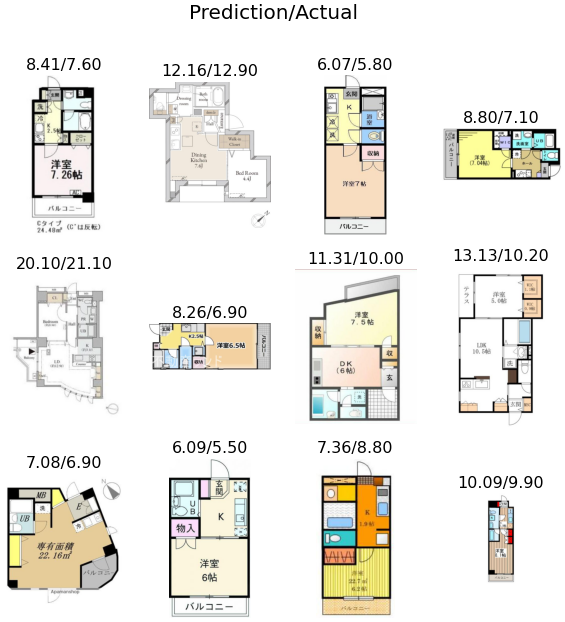

In [327]:
x = show_imgs(random_images(12, seed=2021))

In [339]:
import os
os.listdir("../../paper/assets/")

['Style station log_rent.jpg',
 'Simple Linear Regression.jpg',
 'Linear Regression log.jpg',
 '_20211224_185457screenshot.png',
 '.DS_Store',
 'average_rent.svg',
 'style and apt_rent.jpg',
 'tab_learner.jpg',
 'Station, Style, log rent.jpg',
 'rf.jpg',
 'multimodal.jpg',
 'categories, with apt_style for log_rent.jpg',
 'style and log_rent.jpg',
 'resizes.png',
 'resizes.jpg',
 'With apt_style, log rent.jpg',
 'most_used_stations.jpg',
 'most_used_stations.png',
 'linear Regressoin log rent.jpg',
 'random_table.png',
 'Linear Regression.jpg',
 'Style, station, rent.jpg',
 'viz_learner.jpg',
 'Random Forest.jpg']

In [342]:
x.savefig("/Users/jiyanschneider/dev/proj//Dropbox/real_estate_analysis/paper/assets/random_table.png", dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: '~/Dropbox/real_estate_analysis/paper/assets/random_table.png'

In [187]:
paths = df.sort_values("viz_preds").iloc[-5:]["rel_image_paths"].to_list()

In [165]:
list(map(load_image, paths))

[<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>]

In [149]:
HTML(sg.render_html())